# CNN for rock-paper-scissors with Keras/TensorFlow

Date: January 4, 2019

Classification:
- rock
- paper
- scissors

## Preparing data set for CNN

In [43]:
DATA_FOLDER = '../thermography/data/'

FILES = 45
TRAINING_FILES = 30 
TEST_FILES = FILES - TRAINING_FILES

In [44]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import time
import random
import os
import sklearn.preprocessing as pp

In [45]:
import glob

data_files = glob.glob(DATA_FOLDER+'*.csv')
class_labels = []

for file in data_files:
    label = file.split('-')[0].replace('\\', '/').split('/')[-1]
    if label not in class_labels:
        class_labels.append(label)

data_set = {}

class_number = 0

for label in class_labels:
    files = glob.glob(DATA_FOLDER+'{}-*.csv'.format(label))
    random.shuffle(files)
    data_set[label] = (files[:TRAINING_FILES], files[TRAINING_FILES:FILES], class_number)
    class_number += 1

training_set = []
test_set = []

for k, v in data_set.items():
    files = v[0]
    class_number = v[2]
    for file in files:
        with open(file) as f:
            data = np.array(f.read().split(',')).astype(float)
            training_set.append((pp.scale(data), class_number))
    files = v[1]
    for file in files:
        with open(file) as f:
            data = np.array(f.read().split(',')).astype(float)
            test_set.append((pp.scale(data), class_number))
random.shuffle(training_set)
random.shuffle(test_set)

class_labels = [None for _ in range(len(data_set))]

# Class number and class labels
for k,v in data_set.items():
    print('{}: {}'.format(v[2],k))
    class_labels[v[2]] = k
    
import yaml
with open(DATA_FOLDER+'class_labels.yaml', 'w') as f:
    yaml.dump(class_labels, f)

0: paper
1: rock
2: scissors


array([[-0.61024783, -0.52619648,  1.07077919,  1.35095036, -0.24602531,
        -1.08653881, -1.17059017, -1.36670998],
       [-0.52619648, -0.41412801,  1.266899  ,  1.35095036,  0.65052243,
        -0.890419  , -1.17059017, -1.36670998],
       [-0.52619648,  0.70655667,  1.63112152,  1.63112152,  1.43500171,
        -0.41412801, -1.03050458, -1.25464152],
       [-0.33007666,  1.43500171,  1.54707017,  1.71517288,  1.54707017,
         0.70655667, -0.890419  , -1.17059017],
       [ 0.31431703,  0.03414586,  1.266899  ,  1.49103594,  1.49103594,
         1.07077919, -0.13395684, -0.97447035],
       [-0.69429918, -0.890419  ,  0.23026568,  1.21086477,  1.07077919,
         0.31431703,  0.03414586, -0.41412801],
       [-1.25464152, -1.03050458, -0.61024783,  0.98672784,  0.37035126,
         0.51043685, -0.69429918, -0.890419  ],
       [-1.25464152, -1.03050458, -1.03050458, -0.47016224,  0.23026568,
        -0.52619648, -0.69429918, -1.08653881]])

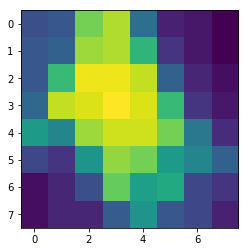

In [46]:
train_data, train_labels = [], []
test_data, test_labels = [], []
for img, label in training_set:
    train_data.append(img)
    train_labels.append(label)
for img, label in test_set:
    test_data.append(img)
    test_labels.append(label)
train_data = np.array(train_data).reshape((TRAINING_FILES*len(class_labels), 8, 8, 1))
train_labels = np.array(train_labels, dtype='uint8')
test_data = np.array(test_data).reshape((TEST_FILES*len(class_labels), 8, 8, 1))
test_lables = np.array(test_labels, dtype='uint8')
#train_data.shape

from keras.utils import to_categorical

train_labels=to_categorical(train_labels)
test_labels=to_categorical(test_labels)

plt.imshow(train_data[12,:,:,0])
train_data[12,:,:,0]

### CNN model

In [47]:
from keras import layers
from keras import models

model = models.Sequential()

model.add(layers.Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=(8, 8, 1)))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(class_labels), activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 8, 8, 16)          160       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 4, 4, 16)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 4, 4, 32)          4640      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 2, 2, 32)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 128)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               33024     
__________

In [48]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

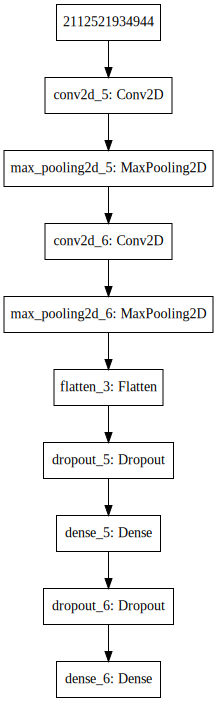

In [49]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

## Training CNN

In [50]:
EPOCHS = 80
history = model.fit(train_data, train_labels, epochs=EPOCHS, validation_data=(test_data, test_labels))

Train on 90 samples, validate on 45 samples
Epoch 1/80
90/90 [==============================] - 0s 5ms/step - loss: 1.2161 - acc: 0.3000 - val_loss: 1.0374 - val_acc: 0.3556
Epoch 2/80
90/90 [==============================] - 0s 199us/step - loss: 1.0992 - acc: 0.4222 - val_loss: 0.9781 - val_acc: 0.6444
Epoch 3/80
90/90 [==============================] - 0s 299us/step - loss: 1.0043 - acc: 0.5778 - val_loss: 0.9319 - val_acc: 0.6889
Epoch 4/80
90/90 [==============================] - 0s 266us/step - loss: 0.9490 - acc: 0.5889 - val_loss: 0.8753 - val_acc: 0.7111
Epoch 5/80
90/90 [==============================] - 0s 344us/step - loss: 0.9691 - acc: 0.5000 - val_loss: 0.8310 - val_acc: 0.9111
Epoch 6/80
90/90 [==============================] - 0s 277us/step - loss: 0.9366 - acc: 0.5778 - val_loss: 0.7896 - val_acc: 0.7778
Epoch 7/80
90/90 [==============================] - 0s 299us/step - loss: 0.8703 - acc: 0.6000 - val_loss: 0.7485 - val_acc: 0.8000
Epoch 8/80
90/90 [================

90/90 [==============================] - 0s 177us/step - loss: 0.0740 - acc: 0.9778 - val_loss: 0.0529 - val_acc: 0.9778
Epoch 63/80
90/90 [==============================] - 0s 222us/step - loss: 0.0772 - acc: 0.9667 - val_loss: 0.0437 - val_acc: 0.9778
Epoch 64/80
90/90 [==============================] - 0s 177us/step - loss: 0.0743 - acc: 0.9889 - val_loss: 0.0561 - val_acc: 0.9778
Epoch 65/80
90/90 [==============================] - 0s 177us/step - loss: 0.0616 - acc: 0.9778 - val_loss: 0.0480 - val_acc: 0.9778
Epoch 66/80
90/90 [==============================] - 0s 177us/step - loss: 0.0702 - acc: 0.9889 - val_loss: 0.0690 - val_acc: 0.9778
Epoch 67/80
90/90 [==============================] - 0s 255us/step - loss: 0.0547 - acc: 0.9889 - val_loss: 0.0450 - val_acc: 0.9778
Epoch 68/80
90/90 [==============================] - 0s 211us/step - loss: 0.0405 - acc: 1.0000 - val_loss: 0.0594 - val_acc: 0.9778
Epoch 69/80
90/90 [==============================] - ETA: 0s - loss: 0.0554 - acc

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


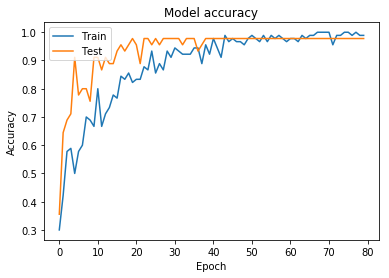

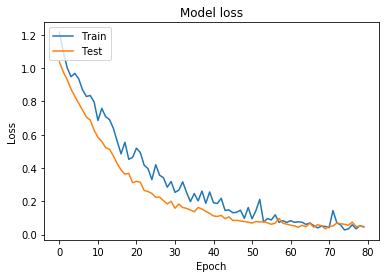

In [51]:
print(history.history.keys())

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Save the model

In [52]:
import datetime

dt = datetime.datetime.today().strftime('%Y%m%d%H%M%S')
filename = 'rock_paper_scissors_cnn_{}.h5'.format(dt)
model.save(filename)

## Load the model

In [53]:
del model
model = models.load_model(filename)

## Confirmation

In [54]:
import numpy as np
import matplotlib.pyplot as plt
train_data.shape

(90, 8, 8, 1)

In [55]:
layer_outputs = [layer.output for layer in model.layers]
#layer_outputs

In [56]:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(test_data)
#activations[0][0,:,:,0].shape

In [57]:
class_labels

['paper', 'rock', 'scissors']

In [58]:
(activations[-1][:10]*100).astype(int)

array([[ 0,  0, 99],
       [99,  0,  0],
       [97,  0,  2],
       [ 6, 93,  0],
       [ 6, 78, 15],
       [ 0,  0, 99],
       [99,  0,  0],
       [99,  0,  0],
       [ 1,  0, 98],
       [99,  0,  0]])

In [59]:
test_labels[:10].astype(int)

array([[0, 0, 1],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 0, 1],
       [1, 0, 0],
       [1, 0, 0],
       [0, 0, 1],
       [1, 0, 0]])

In [60]:
def plot_layer(activations, sample, layer):
    a = activations[layer].shape
    rows = int(a[3]/4)
    fig, axarr = plt.subplots(rows, 4, figsize=[20,15])
    for i in range(a[3]):
        row = int(i/4)
        x, y = row, i-4*row
        axarr[x, y].imshow(activations[layer][sample, :, :, i])
        axarr[x, y].set_xticks([])
        axarr[x, y].set_yticks([])

'paper'

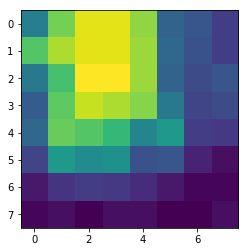

In [61]:
image_number = 10

plt.imshow(test_data[image_number,:,:,0])
class_labels[np.argmax(test_labels[image_number])]

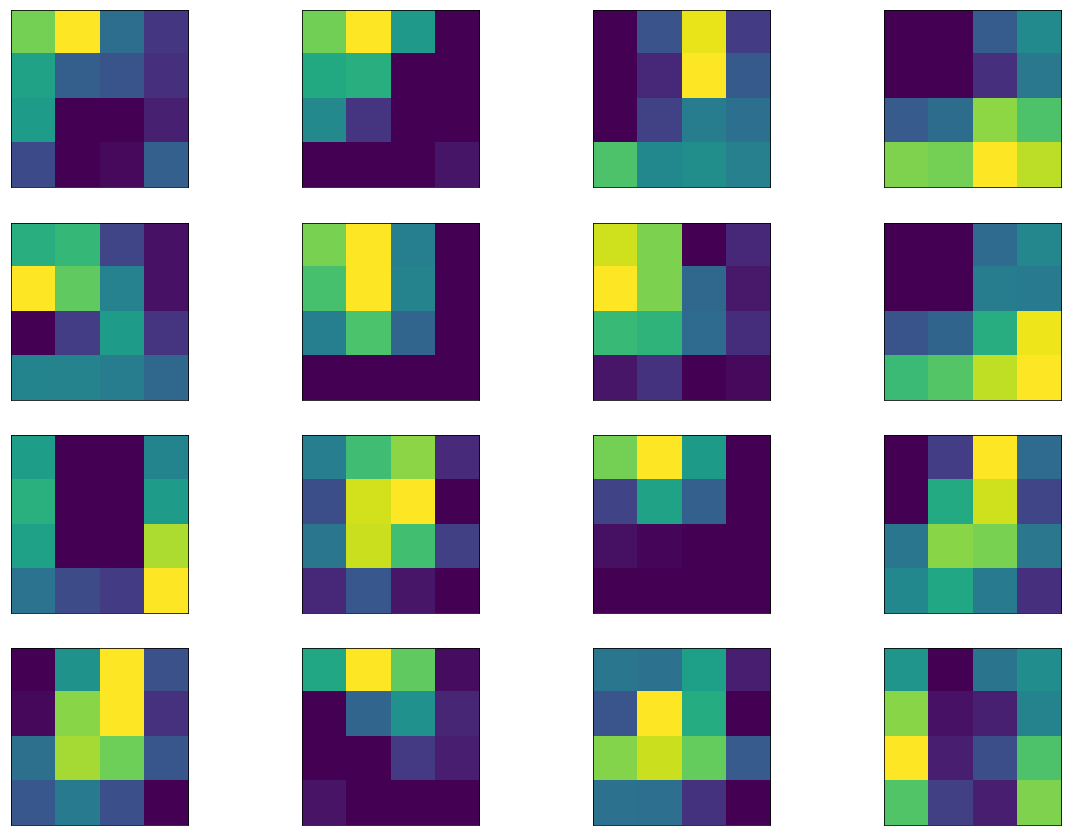

In [62]:
plot_layer(activations, image_number, 1)

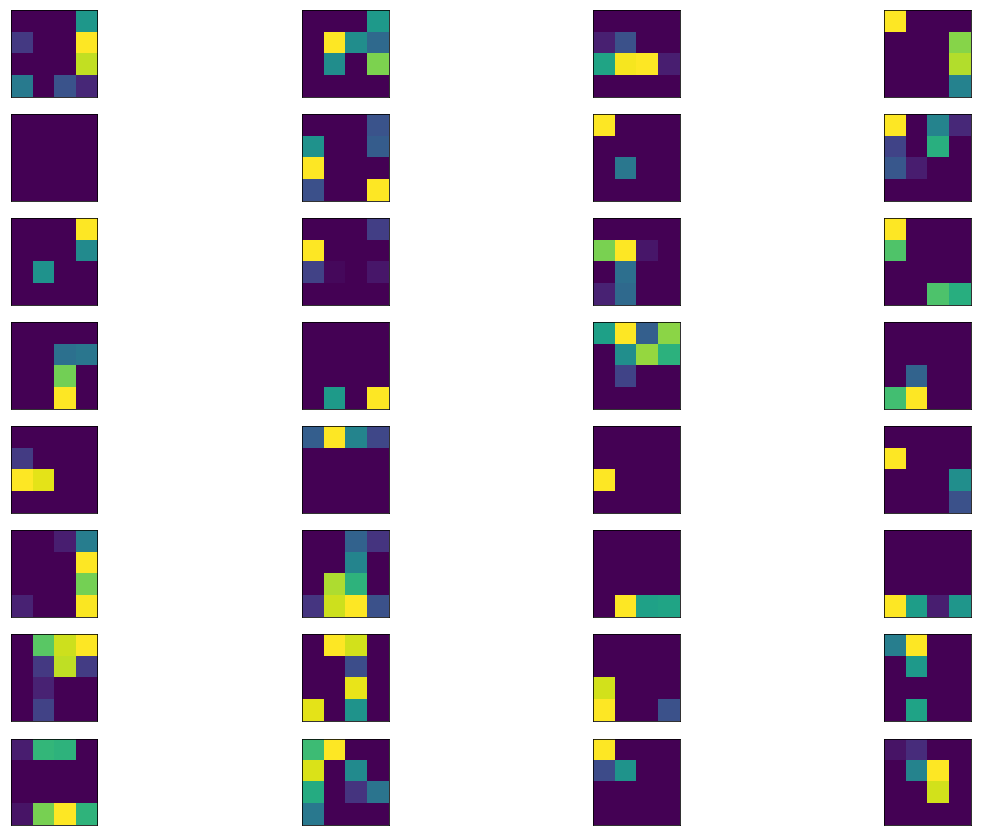

In [63]:
plot_layer(activations, image_number, 2)